## 1. State the question and determine required data

In recent times, there was an outbreak of the covid-19 disease and in our due to the changing climatic patterns especially cold conditions, many of our people are prone to pneumonia.<br>
The question to be answered is whether it is possibe to predict if a patient is suffering fro either covid-19 or pneumonia. <br>
The dataset required is one that has lung x-ray images that can be used to perform the predictions

In [5]:
#import all the necessary libraries

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.image import imread
import os
import random
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Activation, Dropout,  Flatten, Dense,MaxPool2D
 #for explainable
from skimage.segmentation import mark_boundaries
import lime
from lime import lime_image


## 2. Acquire the data in an accessible format

The dataset used is Chest X-ray (Covid-19 & Pneumonia) found in kaggle  
upload data(train&test)

In [2]:
data_path = '../input/chest-xray-covid19-pneumonia/Data/'
train_path = '../input/chest-xray-covid19-pneumonia/Data/train/'
test_path = '../input/chest-xray-covid19-pneumonia/Data/test/'
os.listdir(train_path)

['PNEUMONIA', 'NORMAL', 'COVID19']

As seen in the cell above, there are three classes: Pneumonia, Normal and covid19 infected lungs

## 3. Identify and correct missing data points/anomalies as required <br> and <br> 4. Prepare the data for the machine learning model 

In [3]:
#Observation of an image sample for each category of X-ray

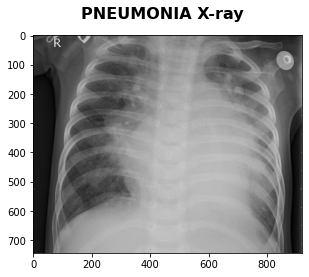

In [3]:
pneumonia_sample = imread(train_path+"/PNEUMONIA"+"/PNEUMONIA(3140).jpg")
plt.imshow(pneumonia_sample)
plt.suptitle('PNEUMONIA X-ray', fontsize=16, weight='bold');

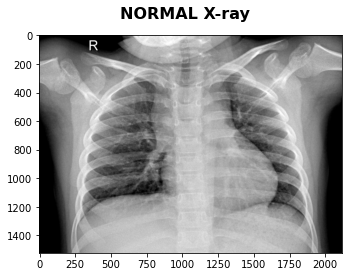

In [4]:
normal_sample = imread(train_path+"/NORMAL"+"/NORMAL(285).jpg")
plt.imshow(normal_sample)
plt.suptitle('NORMAL X-ray', fontsize=16, weight='bold');

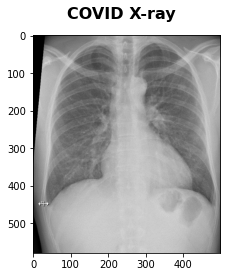

In [5]:
covid_sample = imread(train_path+"/COVID19"+"/COVID19(105).jpg")
plt.imshow(covid_sample)
plt.suptitle('COVID X-ray', fontsize=16, weight='bold');

# **Data Augmantion**

In [13]:
# Augmentation is used in image-based deep learning tasks to increase the amount and variance of training data.
#This includes zooming,rotation and flipping as I have done below
#Augmentation is only done on the training set, never on the validation set.
#We rescale the pixel values so that they lie within a confined range


In [14]:
#Data generator supports preprocessing 
#it normalizes the images (dividing by 255) and crops the center (224 x 224) portion of the image.
#If any dimension (height or width) of an image less than 224 pixels, that image is deleted.
#I want to generate batches of data points (16) and feed them to the model.


In [6]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   zoom_range = 0.2,
                                   rotation_range=15,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 16,
                                                 class_mode = 'categorical',
                                                 shuffle=True)

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 16,
                                            class_mode = 'categorical',
                                            shuffle = False)

Found 5144 images belonging to 3 classes.
Found 1288 images belonging to 3 classes.


As seen in the cell above, there are 5144 images used for training and 1288 images for validation both with 3 classes each

## 5.Establish a baseline model that you aim to exceed 

## Built Convolutional Neural Network

CNNs are a class of Deep Neural Networks that can recognize and classify particular features from images and are widely used for analyzing visual images. The working of CNN is that it extracts features from images and creates new features which it utilizes in performing classification

CONVOLUTION LAYER
In this layer, the mathematical operation of convolution is performed between the input image and a filter of a particular size and in this case 224*224. The result is referred as the Feature map, and it contains information about the image such as its corners and edges.

POOLING LAYER
The primary goal of this layer is to reduce the size of the convolved feature map in order to reduce computational costs. This is accomplished by reducing the connections between layers and operating independently on each feature map. Max Pooling will take the largest element is from feature map. 

DROPOUT It improves the performance of a machine learning model by preventing overfitting by simplifying the network. During training, it removes neurons from neural networks. I drop 0.2 meaning 20% of the nodes are dropped

ACTIVATION FUNCTIONS In a CNN model, activation functions determine whether or not a neuron should be activated. I use relu and softmax because it is a multi class classification

I use sequential model type as it permits to build the model layer by layer by using the add() function. I use the Dense layer for output layers. The activation used is the 'Softmax,' which will give a probability for each class that adds up to 1. The model will predict based on the class with the highest probability.

Lastly I compile the model with an optimizer, a loss function and print

In [7]:
image_size = (224,224,3)

model = Sequential()
model.add(Conv2D(64,(3,3),activation = "relu", input_shape = image_size))
model.add(MaxPool2D())

model.add(Conv2D( 128, (3,3), activation = "relu"))
model.add(MaxPool2D())
model.add(Dropout(0.2))

model.add(Conv2D( 256,(3,3), activation = "relu"))
model.add(MaxPool2D())
model.add(Dropout(0.2))

model.add(Conv2D( 512,(3,3), activation = "relu"))
model.add(MaxPool2D())
model.add(Dropout(0.2))


model.add(Flatten())
model.add(Dense(512, activation = "relu"))
model.add(Dropout(0.15))

model.add(Dense(3, activation = "softmax"))


model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
model.summary()

2022-09-14 13:38:26.254778: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-14 13:38:26.392913: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-14 13:38:26.393770: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 128)     73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 54, 54, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 256)       295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 256)       0

2022-09-14 13:38:26.395633: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-14 13:38:26.395930: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-14 13:38:26.396744: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-14 13:38:26.397468: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [ ]:
#plot model layer

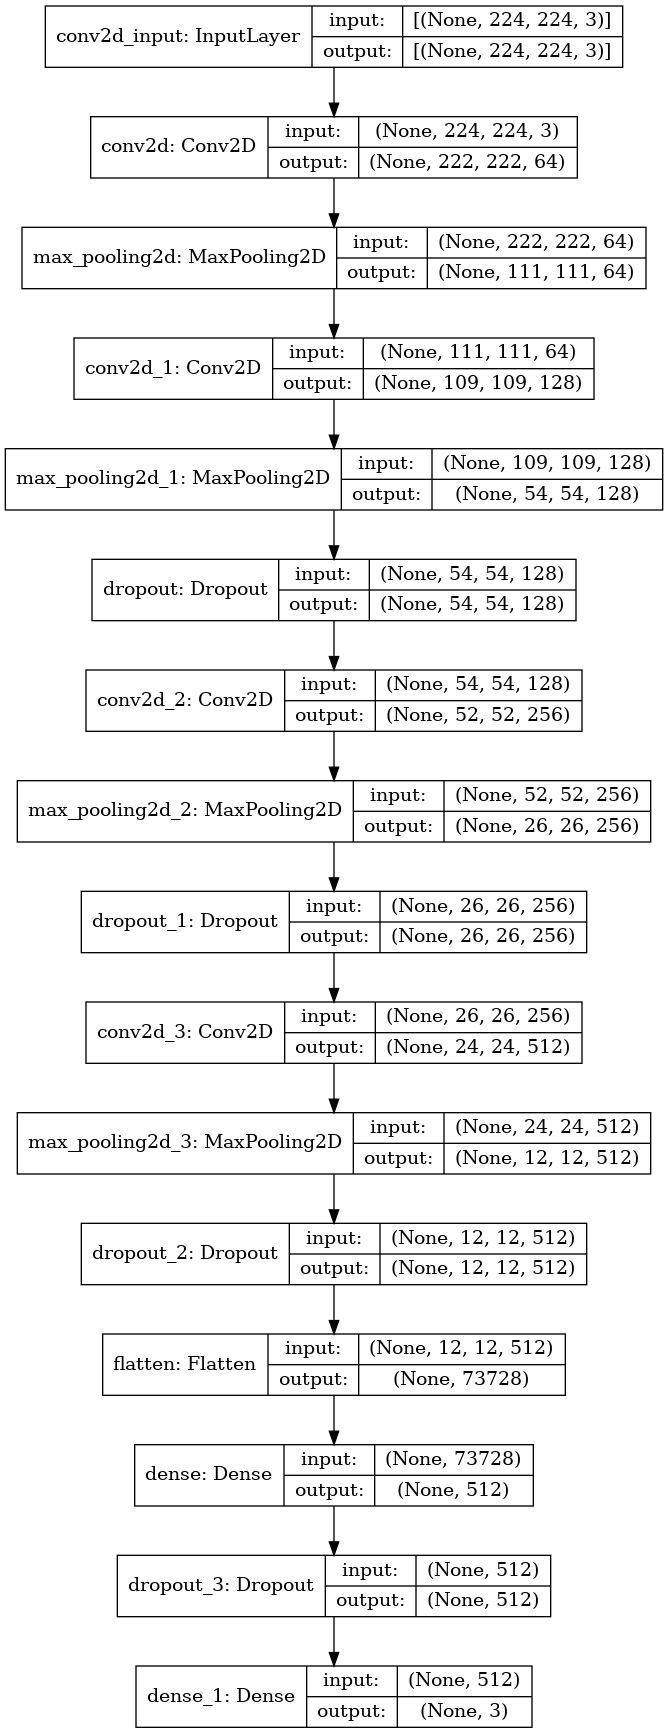

In [8]:
keras.utils.plot_model(model,show_shapes=True)

## 6.Train the model on the training data 


The model has ten epochs meaning it will attempt to train 10 timeseach epoch contains 128 steps

In [18]:
#fit and train the model

In [9]:
history = model.fit(training_set, validation_data=test_set,steps_per_epoch=128,epochs=10)


2022-09-14 13:38:31.067301: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-09-14 13:38:33.263633: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


128/128 [==============================] - 139s 1s/step - loss: 0.8572 - accuracy: 0.6738 - val_loss: 0.4603 - val_accuracy: 0.8828
Epoch 2/10
128/128 [==============================] - 110s 858ms/step - loss: 0.5090 - accuracy: 0.7917 - val_loss: 0.2985 - val_accuracy: 0.9123
Epoch 3/10
128/128 [==============================] - 105s 821ms/step - loss: 0.4187 - accuracy: 0.8330 - val_loss: 0.3669 - val_accuracy: 0.8696
Epoch 4/10
128/128 [==============================] - 102s 800ms/step - loss: 0.4274 - accuracy: 0.8368 - val_loss: 0.2524 - val_accuracy: 0.9084
Epoch 5/10
128/128 [==============================] - 100s 785ms/step - loss: 0.3800 - accuracy: 0.8574 - val_loss: 0.3123 - val_accuracy: 0.8828
Epoch 6/10
128/128 [==============================] - 98s 767ms/step - loss: 0.3594 - accuracy: 0.8652 - val_loss: 0.2533 - val_accuracy: 0.9099
Epoch 7/10
128/128 [==============================] - 97s 763ms/step - loss: 0.3910 - accuracy: 0.8442 - val_loss: 0.2829 - val_accuracy: 0

## Visualize the training and validation accuracies and loss using matplotlib 

In [10]:
print("training_accuracy", history.history['accuracy'][-1])
print("validation_accuracy", history.history['val_accuracy'][-1])

training_accuracy 0.9072265625
validation_accuracy 0.9301242232322693


In [11]:
#The cell above shows the accuracies achieved on training and validation datasets respectively

<AxesSubplot:>

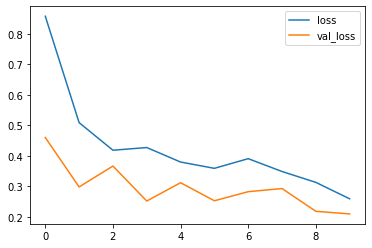

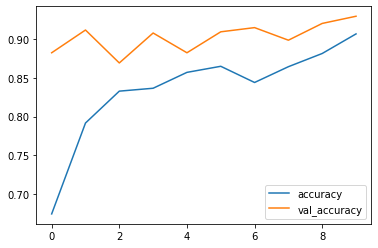

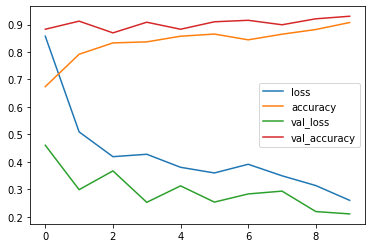

In [11]:
losses = pd.DataFrame(history.history)
losses.head()
losses[['loss','val_loss']].plot() 
losses[['accuracy','val_accuracy']].plot() 
losses.plot()

In [15]:
#It is observed that the model acquires high accuracies.
#It acquires higher accuracies in validation than in training
#This is a sign of good fit

# Save the model

In [ ]:
#The model is save so that it is easily callable in the flask script when building the UI


In [12]:
model.save('covid_model.h5')

## 10.Interpret model and report results visually and numerically  

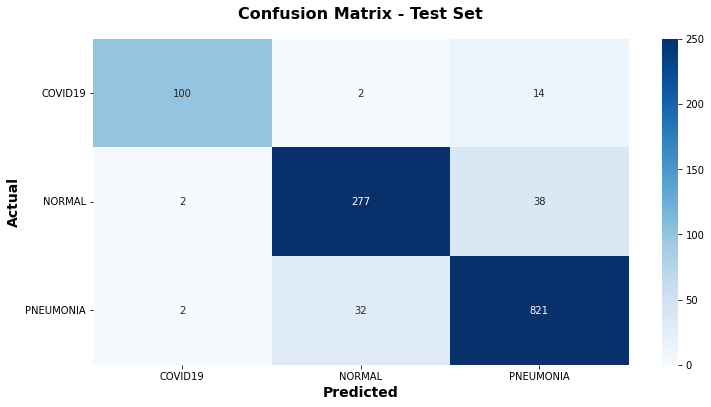

In [13]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support, accuracy_score


classes = ["COVID19", "NORMAL", "PNEUMONIA"]

y_pred = model.predict(test_set)
predictions = np.array(list(map(lambda x: np.argmax(x), y_pred)))

y_true=test_set.classes

CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index =classes)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

In [14]:
print(classification_report(y_true, predictions))

              precision    recall  f1-score   support

           0       0.96      0.86      0.91       116
           1       0.89      0.87      0.88       317
           2       0.94      0.96      0.95       855

    accuracy                           0.93      1288
   macro avg       0.93      0.90      0.91      1288
weighted avg       0.93      0.93      0.93      1288



In [15]:
class_dict = {0:'COVID19',
              1:'NORMAL',
              2:'PNEUMONIA'}

## 7.Make predictions on the test data

prediction:  COVID19


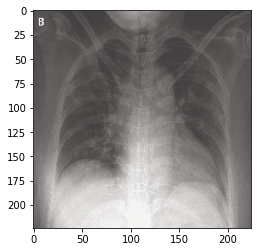

In [16]:
file_path =  '/test/COVID19/COVID19(538).jpg'
test_image = cv2.imread(data_path + file_path)
test_image = cv2.resize(test_image, (224,224),interpolation=cv2.INTER_NEAREST)
plt.imshow(test_image)
test_image = np.expand_dims(test_image,axis=0)
probs = model.predict(test_image)
pred_class = np.argmax(probs)

pred_class = class_dict[pred_class]

print('prediction: ',pred_class)

prediction:  PNEUMONIA


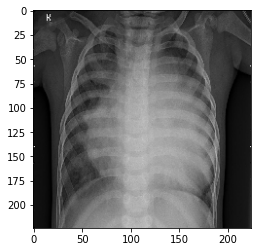

In [17]:
file_path =  '/test/PNEUMONIA/PNEUMONIA(3420).jpg'
test_image = cv2.imread(data_path + file_path)
test_image = cv2.resize(test_image, (224,224),interpolation=cv2.INTER_NEAREST)
plt.imshow(test_image)
test_image = np.expand_dims(test_image,axis=0)
probs = model.predict(test_image)
pred_class = np.argmax(probs)

pred_class = class_dict[pred_class]

print('prediction: ',pred_class)

## 8.Compare predictions to the known test set targets and calculate performance metrics

In [19]:
#Explainable AI using lime

In [18]:
def find_true_class(file_path):
    true_class = None
    if 'COVID19' in file_path:
        true_class = 'COVID19'
    elif 'PNEUMONIA' in file_path:
        true_class = 'PNEUMONIA'
    elif 'NORMAL' in file_path:
        true_class = 'NORMAL'
    return true_class

In [19]:
def visualize(file_path,ax,text_loc):
    test_image = cv2.imread(data_path + file_path)
    test_image = cv2.resize(test_image, (224,224),interpolation=cv2.INTER_NEAREST)
    test_image = np.expand_dims(test_image,axis=0)
    probs = model.predict(test_image)
    pred_class = np.argmax(probs)
    pred_class = class_dict[pred_class]

    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(test_image[0], model.predict, top_labels=5, hide_color=0, num_samples=1000)
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)


    ax.imshow(mark_boundaries(temp, mask))
    fig.text(text_loc, 0.9, "Predicted Class: " + pred_class , fontsize=13)
    true_class = find_true_class(file_path)
    if true_class is not None:
        fig.text(text_loc, 0.86, "Actual Class: " + true_class , fontsize=13)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

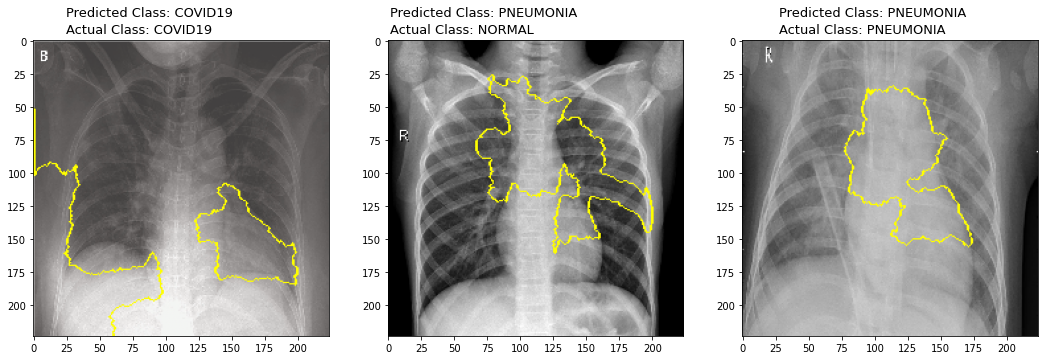

In [20]:
fig,ax = plt.subplots(1,3,figsize=(18,6))
visualize('/test/COVID19/COVID19(538).jpg',ax[0],0.15)
visualize('/test/NORMAL/NORMAL(1540).jpg',ax[1],0.4)
visualize('/test/PNEUMONIA/PNEUMONIA(3431).jpg',ax[2],0.7)